In [1]:
!pip install -Uqq git+https://github.com/jaysinghr/DL-to-Diffusion@develop

In [1]:
#|default_exp activations

# Activation stats

In [3]:
#|export
from __future__ import annotations
import random, math
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

import torch
import fastcore.all as fc

from minimalai.datasets import *
from minimalai.learner import *

In [4]:
import torch.nn.functional as F
import matplotlib as mpl
from pathlib import Path
from operator import attrgetter, itemgetter
from contextlib import contextmanager

from torch import tensor, nn, optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

In [5]:
#|export
def set_seed(seed, deterministic=False):
    """
    Set the seed for random number generators in PyTorch, Python, and NumPy.

    Args:
    - seed (int): The seed value to use for random number generation.
    - deterministic (bool): If True, use deterministic algorithms in PyTorch.

    Returns:
    - None
    """
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [6]:
# Define the keys for image and label
image_key, label_key = 'image', 'label'
# Specify the name of the dataset (e.g., "fashion_mnist")
dataset_name = "fashion_mnist"

# Load the dataset using the specified name
dataset_dict = load_dataset(dataset_name)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
# Define the function to transform the data inplace
@apply_inplace_transformation
def transform_images_inplace(batch):
    """
    Transform the images in the batch to tensors and flatten them inplace.

    Args:
    - batch (dict): A dictionary containing the batch of data.

    Returns:
    - dict: The transformed batch with images flattened as tensors.
    """
    batch[image_key] = [TF.to_tensor(image) for image in batch[image_key]]
    return batch

In [8]:
# Define the batch size for the data loader
batch_size = 1024

# Apply the transform function `transform_images_inplace` to the dataset `loaded_dataset`
transformed_dataset = dataset_dict.with_transform(transform_images_inplace)

In [9]:
# Create data loaders from the transformed dataset `transformed_dataset` with the specified batch size `batch_size` and number of workers `num_workers`
data_loaders = DataLoaders.from_dataset_dict(transformed_dataset, batch_size, num_workers=4)

# Get the training data loader from the created data loaders
train_data_loader = data_loaders.train_loader

# Get a batch of data from the training data loader
inputs_batch, labels_batch = next(iter(train_data_loader))

# Print the shape of the input batch and the first 10 labels
print("Input Batch Shape:", inputs_batch.shape)
print("First 10 Labels:", labels_batch[:10])

Input Batch Shape: torch.Size([1024, 1, 28, 28])
First 10 Labels: tensor([5, 9, 8, 9, 5, 2, 4, 8, 0, 5])


## Baseline

In [10]:
def convolutional_layer(input_channels, output_channels, kernel_size=3, stride=2, apply_activation=True):
    """
    Create a convolutional layer followed by an optional activation function.

    Args:
    - input_channels (int): Number of input channels.
    - output_channels (int): Number of output channels.
    - kernel_size (int): Kernel size for the convolutional layer.
    - stride (int): Stride for the convolutional layer.
    - apply_activation (bool): If True, apply ReLU activation after the convolutional layer.

    Returns:
    - nn.Module: Convolutional layer with optional activation.
    """
    layer = nn.Conv2d(input_channels, output_channels, stride=stride, kernel_size=kernel_size, padding=kernel_size//2)
    if apply_activation:
        layer = nn.Sequential(layer, nn.ReLU())
    return layer

def cnn_layers():
    """
    Create a list of convolutional layers for a CNN architecture.

    Returns:
    - list: List of convolutional layers.
    """
    layers = [
        convolutional_layer(1, 8, kernel_size=5),  # 14x14
        convolutional_layer(8, 16),               # 7x7
        convolutional_layer(16, 32),              # 4x4
        convolutional_layer(32, 64),              # 2x2
        convolutional_layer(64, 10, apply_activation=False),  # 1x1
        nn.Flatten()
    ]
    return layers

We want to train quickly, so that means training at a high learning rate.

In [11]:
from torcheval.metrics import MulticlassAccuracy

In [12]:
metrics = MetricsCallback(accuracy=MulticlassAccuracy())
cbs = [TrainCallback(), DeviceCallback(), metrics, ProgressCallback(plot=True)]

In [13]:
def fit(model, epochs=1, additional_callbacks=None):
    """
    Train a given model for the specified number of epochs.

    Args:
    - model (nn.Module): The model to be trained.
    - epochs (int): Number of epochs for training.
    - additional_callbacks (list): Additional callbacks to be used during training.

    Returns:
    - Learner: The trained Learner object.
    """
    callbacks = fc.L(additional_callbacks) if additional_callbacks else fc.L()
    learner = Learner(model, 
                      data_loaders, 
                      loss_function=F.cross_entropy, 
                      learning_rate=0.6, 
                      callbacks=cbs + callbacks)
    learner.fit(epochs)
    return learner

accuracy,loss,epoch,train
0.163,2.299,0,train
0.199,2.092,0,eval


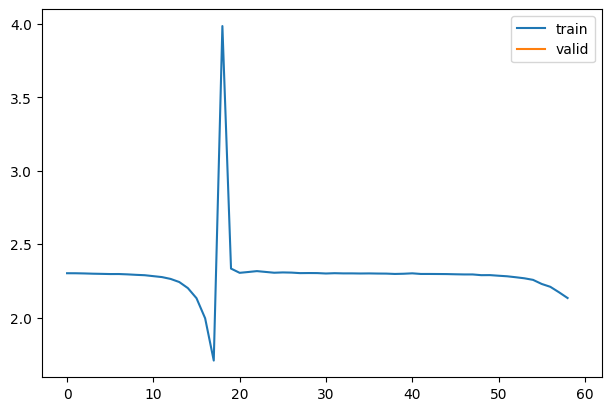

In [14]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

## Hooks

### Manual insertion

In [15]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.activation_means = [[] for _ in layers]
        self.activation_stddevs = [[] for _ in layers]
        
    def __call__(self, input_tensor):
        for i, layer in enumerate(self.layers):
            input_tensor = layer(input_tensor)
            self.activation_means[i].append(to_cpu(input_tensor).mean())
            self.activation_stddevs[i].append(to_cpu(input_tensor).std())
        return input_tensor
    
    def __iter__(self):
        return iter(self.layers)

accuracy,loss,epoch,train
0.163,2.299,0,train
0.199,2.092,0,eval


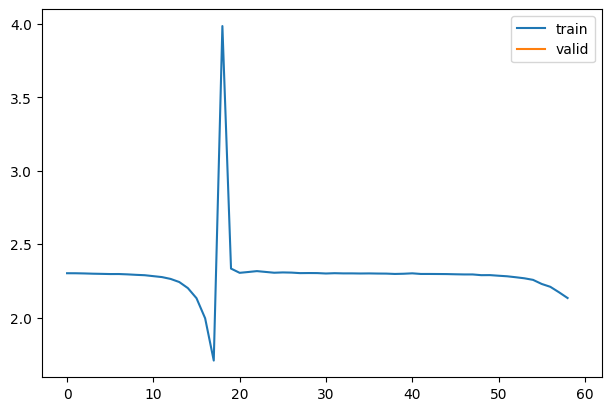

In [16]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

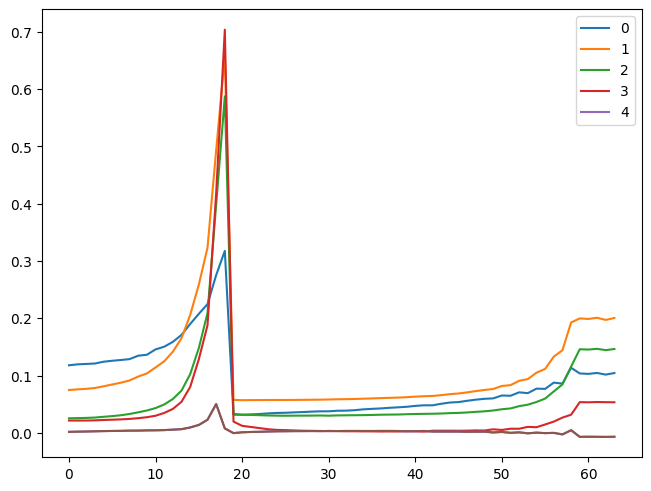

In [17]:
for l in model.activation_means:
    plt.plot(l)
plt.legend(range(5));

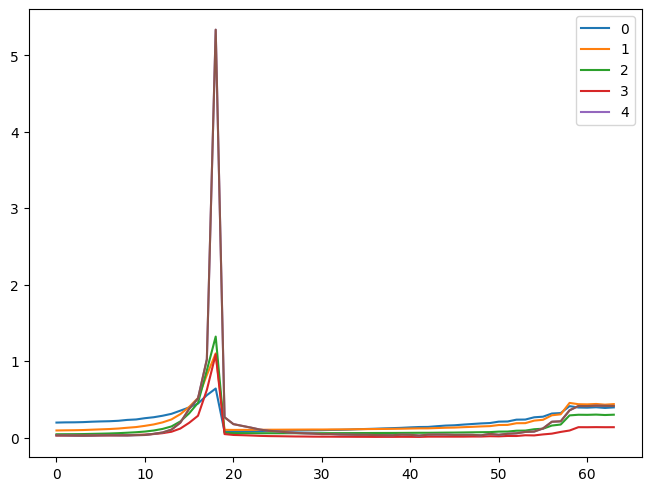

In [18]:
for l in model.activation_stddevs:
    plt.plot(l)
plt.legend(range(5));

### Pytorch hooks

Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook). Hooks don't require us to rewrite the model.

In [19]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output. Here we store the mean and std of the output in the correct position of our list.

In [20]:
activation_means = [[] for _ in model]
activation_stddevs = [[] for _ in model]

In [21]:
def append_stats(layer_index, module, input_tensor, output_tensor):
    activation_means[layer_index].append(to_cpu(output_tensor).mean())
    activation_stddevs[layer_index].append(to_cpu(output_tensor).std())

In [22]:
for layer_index, layer in enumerate(model):
    layer.register_forward_hook(partial(append_stats, layer_index))

accuracy,loss,epoch,train
0.163,2.299,0,train
0.199,2.092,0,eval


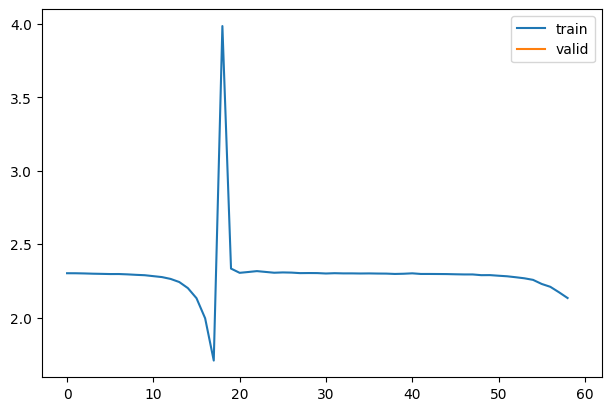

In [23]:
fit(model)

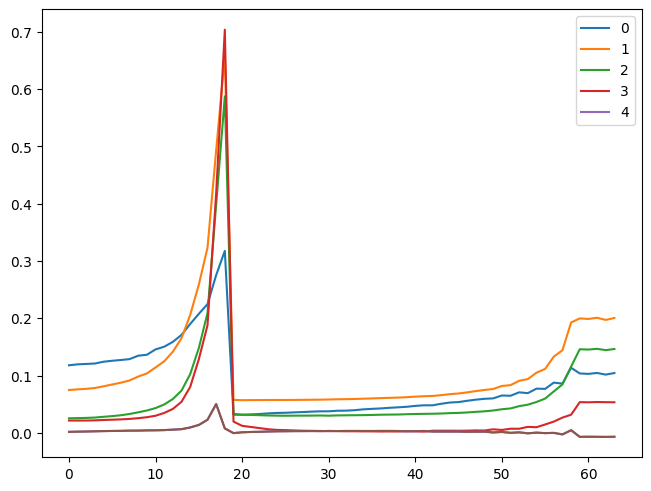

In [24]:
for o in activation_means:
    plt.plot(o)
plt.legend(range(5));

### Hook class

We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

In [25]:
#|export
class Hook():
    def __init__(self, module, function):
        self.hook = module.register_forward_hook(partial(function, self))

    def remove(self):
        self.hook.remove()

    def __del__(self):
        self.remove()

In [26]:
def append_stats(hook, module, input, output):
    if not hasattr(hook, 'stats'):
        hook.stats = ([], [])
    activations = to_cpu(output)
    hook.stats[0].append(activations.mean())
    hook.stats[1].append(activations.std())

In [27]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [28]:
hooks = [Hook(layer, append_stats) for layer in model[:5].children()]

accuracy,loss,epoch,train
0.163,2.299,0,train
0.199,2.092,0,eval


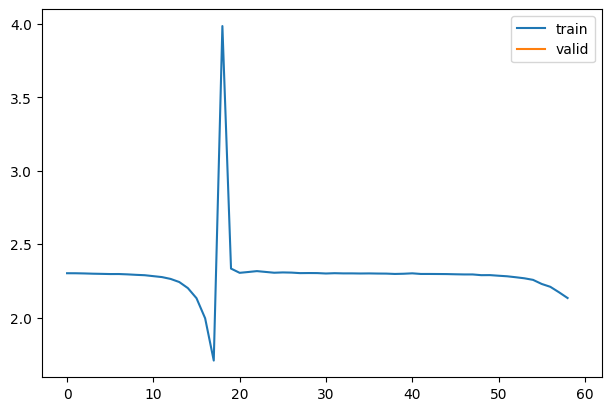

In [29]:
learn = fit(model)

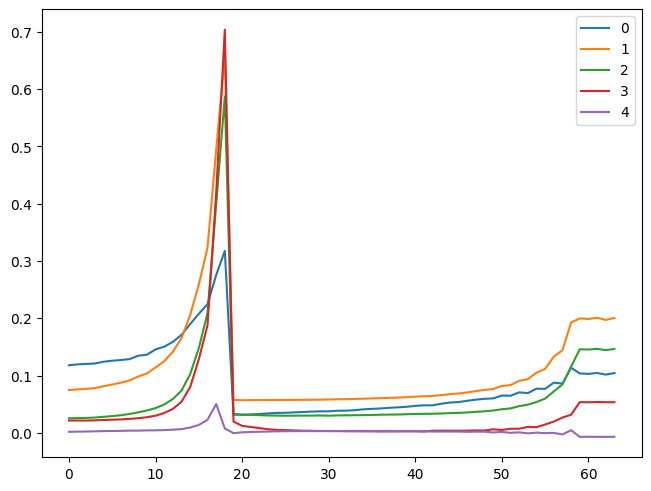

In [30]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));

### A Hooks class

In [31]:
class DummyContextManager:
    def __enter__(self, *args):
        print("Entering the context.")
        return self
    
    def __exit__(self, *args):
        print("Exiting the context.")
        
    def hello(self):
        print("Hello inside the context.")

In [32]:
with DummyContextManager() as dcm:
    dcm.hello()

Entering the context.
Hello inside the context.
Exiting the context.


In [33]:
class DummyList(list):
    def __delitem__(self, i):
        print(f"Say bye to item {i}")
        super().__delitem__(i)

In [34]:
dml = DummyList([1,3,2])
dml

[1, 3, 2]

In [35]:
del(dml[2])
dml

Say bye to item 2


[1, 3]

In [36]:
#| export
class Hooks(list):
    def __init__(self, modules, function):
        super().__init__([Hook(module, function) for module in modules])
    
    def __enter__(self, *args):
        return self
    
    def __exit__(self, *args):
        self.remove()
    
    def __del__(self):
        self.remove()
    
    def __delitem__(self, index):
        self[index].remove()
        super().__delitem__(index)
    
    def remove(self):
        for hook in self:
            hook.remove()

In [37]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.163,2.299,0,train
0.199,2.092,0,eval


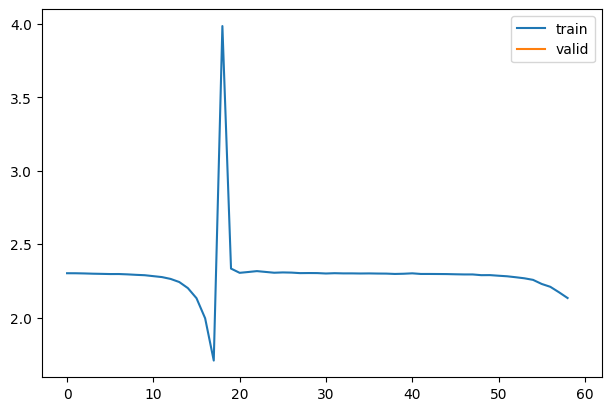

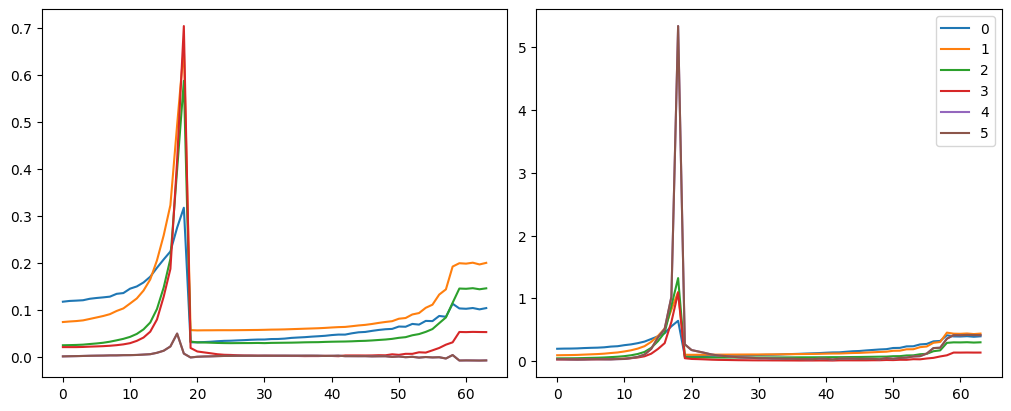

In [38]:
with Hooks(model, append_stats) as hooks:
    fit(model)
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        for i in 0,1: axs[i].plot(h.stats[i])
    plt.legend(range(6));

### HooksCallback

In [39]:
#| export
class HooksCallback(Callback):
    def __init__(self, hook_function, module_filter=fc.noop, on_train=True, on_valid=False, modules=None):
        fc.store_attr()
        super().__init__()
    
    def before_fit(self, learn):
        if self.modules:
            modules = self.modules
        else:
            modules = fc.filter_ex(learn.model.modules(), self.module_filter)
        self.hooks = Hooks(modules, partial(self._hook_function, learn))

    def _hook_function(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training):
            self.hook_function(*args, **kwargs)

    def after_fit(self, learn):
        self.hooks.remove()
    
    def __iter__(self):
        return iter(self.hooks)
    
    def __len__(self):
        return len(self.hooks)

In [40]:
hc = HooksCallback(append_stats, module_filter=fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.163,2.299,0,train
0.199,2.092,0,eval


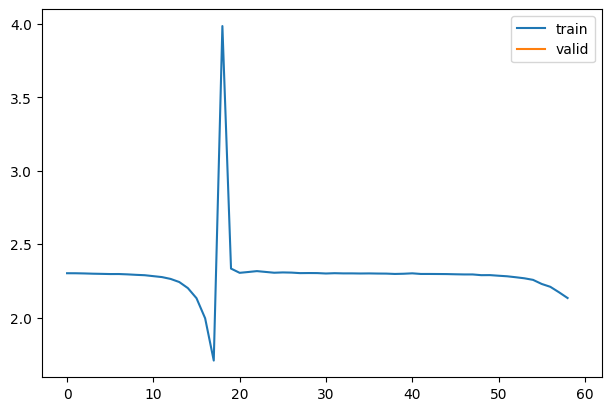

In [41]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, additional_callbacks=[hc])

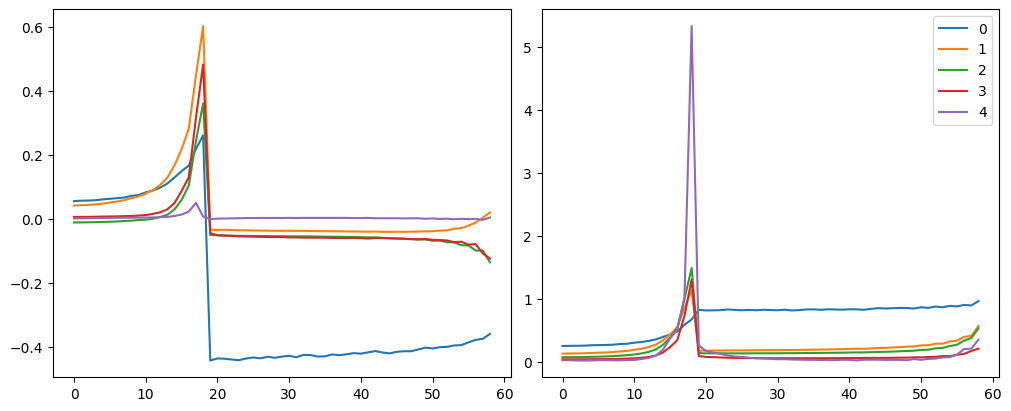

In [42]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1: axs[i].plot(h.stats[i])
plt.legend(range(6));

## Histograms

In [43]:
#| export
def append_stats(hook, module, input_data, output_data):
    if not hasattr(hook, 'stats'):
        hook.stats = ([], [], [])
    activations = to_cpu(output_data)
    hook.stats[0].append(activations.mean())
    hook.stats[1].append(activations.std())
    hook.stats[2].append(activations.abs().histc(40, 0, 10))

accuracy,loss,epoch,train
0.163,2.299,0,train
0.199,2.092,0,eval


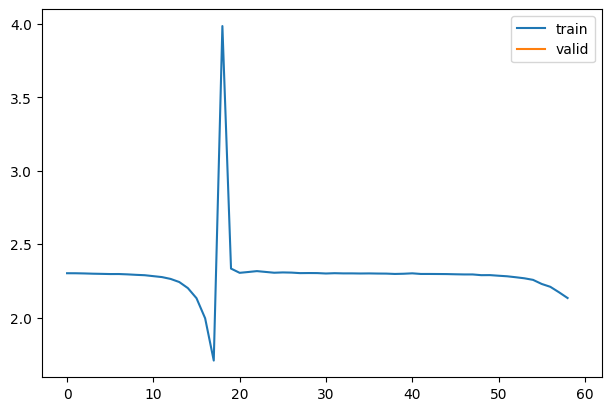

In [44]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, module_filter=fc.risinstance(nn.Conv2d))
fit(model, additional_callbacks=[hc])

In [45]:
#|export
def get_histogram(stats_holder):
    return torch.stack(stats_holder.stats[2]).t().float().log1p()

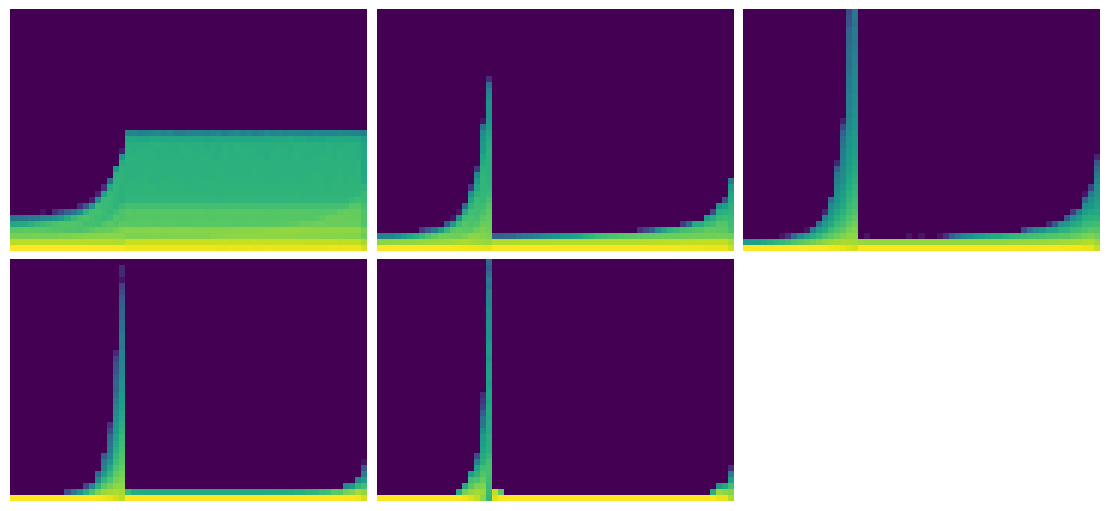

In [46]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flat, hc):
    show_image(get_histogram(h), ax, origin='lower')

In [47]:
#|export
def get_min_percentage(stats_holder):
    histogram = torch.stack(stats_holder.stats[2]).t().float()
    return histogram[0] / histogram.sum(0)

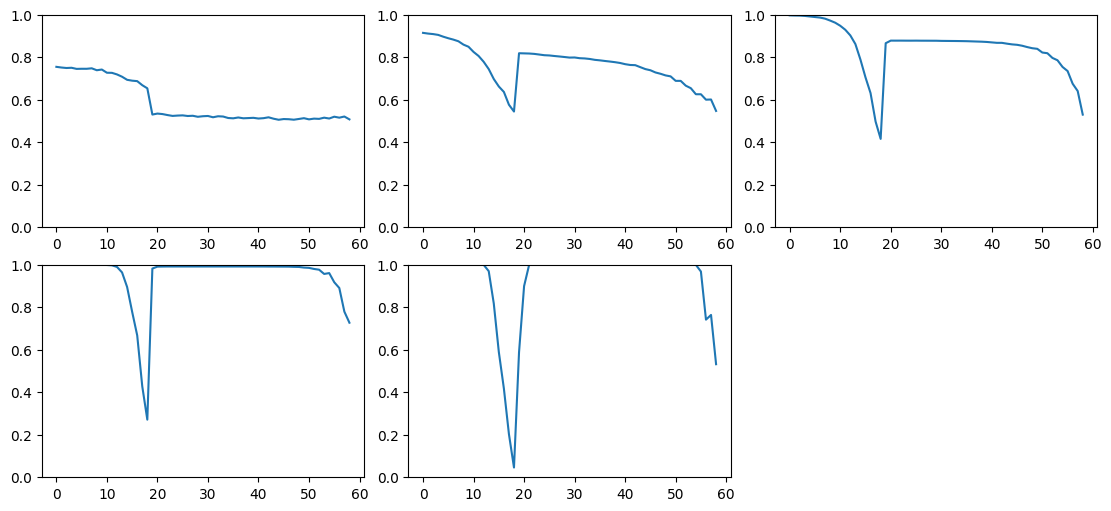

In [48]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flatten(), hc):
    ax.plot(get_min_percentage(h))
    ax.set_ylim(0,1)

## ActivationStats

In [49]:
#|export
class ActivationStatisticsCallback(HooksCallback):
    def __init__(self, module_filter=fc.noop):
        super().__init__(append_stats, module_filter)

    def plot_color_dimensions(self, figsize=(11, 5)):
        fig, axes = get_grid(len(self), figsize=figsize)
        for ax, activation_hook in zip(axes.flat, self):
            show_image(get_histogram(activation_hook), ax, origin='lower')

    def plot_dead_neurons(self, figsize=(11, 5)):
        fig, axes = get_grid(len(self), figsize=figsize)
        for ax, activation_hook in zip(axes.flatten(), self):
            ax.plot(get_min_percentage(activation_hook))
            ax.set_ylim(0, 1)

    def plot_activation_stats(self, figsize=(10, 4)):
        fig, axs = plt.subplots(1, 2, figsize=figsize)
        for activation_hook in self:
            for i in 0, 1:
                axs[i].plot(activation_hook.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

In [50]:
astats = ActivationStatisticsCallback(fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.163,2.299,0,train
0.199,2.092,0,eval


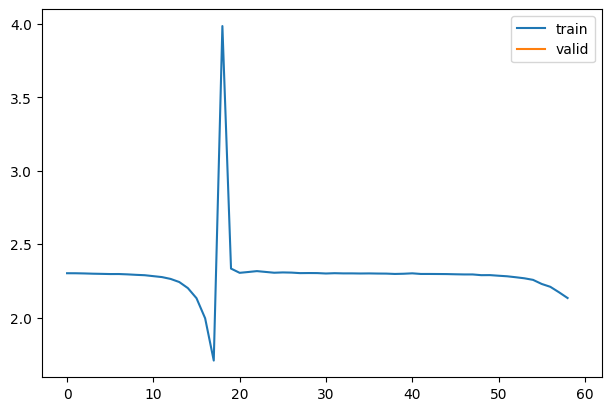

In [51]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, additional_callbacks=[astats]);

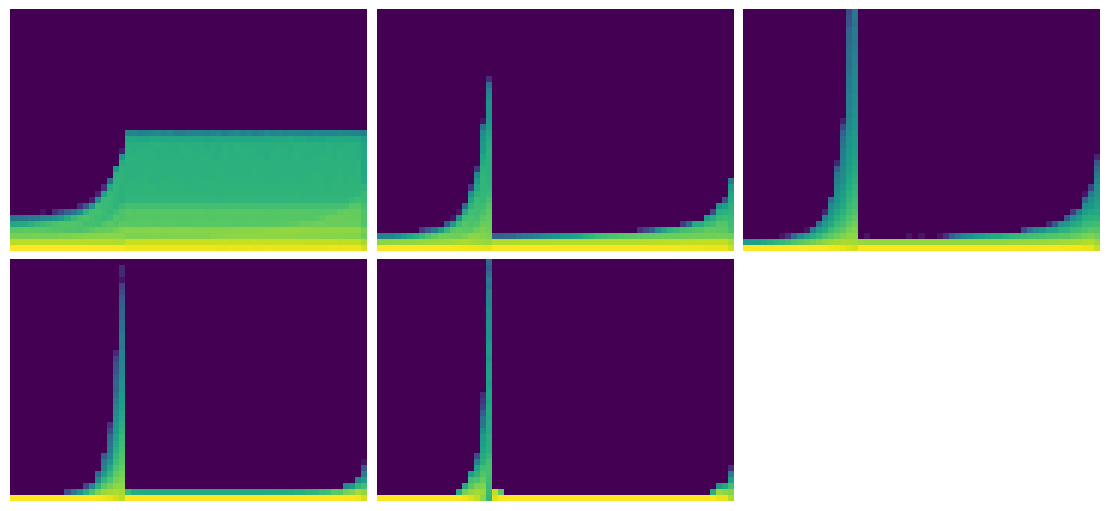

In [52]:
astats.plot_color_dimensions()

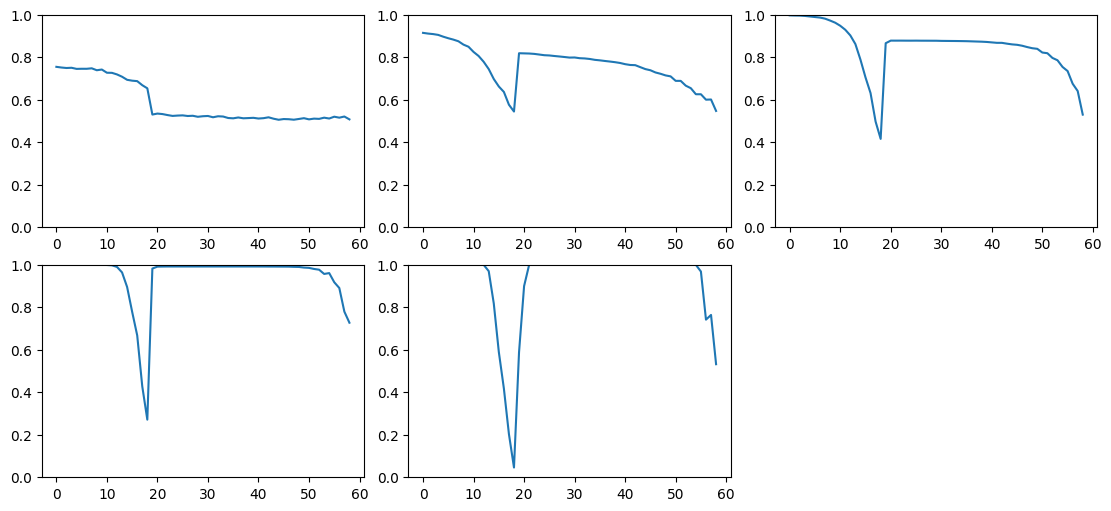

In [53]:
astats.plot_dead_neurons()

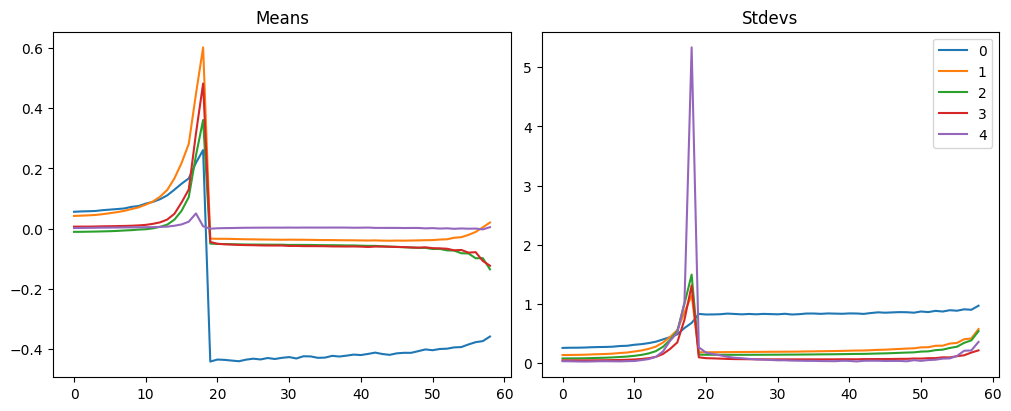

In [54]:
astats.plot_activation_stats()

## Export -

In [2]:
import nbdev; nbdev.nbdev_export()